<h1><center>A Simple Named Entity Recognition Model using  BERT  and Keras</center></h1>
<h4><center>Initially prepared for UC Berkeley MIDS - W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook we investigate how we can leverage BERT (see ["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"](https://arxiv.org/pdf/1810.04805.pdf), by Devlin/Chang/Lee/Toutanova, Google AI Language) for the problem of Named Entity Recognition (NER). Their paper actually contains the NER use case as a fine-tuning example, but we are not striving to replicate necessarily exactly their approach but build the model in the most approachable and 'naive' way, i.e. simply applying a straightforward model that follows intuitively the BERT mantra leveraging its context-based embeddings.


We look at the effect of also fine-tuning BERT layers vs just adding and training classification layers on top of the BERT model and find that in this cursory and certainly incomplete study the re-training of BERT layers does offer some advantages. We also perform a test reducing the training data by 90% and find that the results are still quite decent, re-emphasizing BERT's usefulness in situations where the data set is on the small side.  


## Table of Contents

I. [Introduction & Approach](#ia)   
1. [Introduction](#intro)  
2. [Problem Definition & Metrics](#problem)  
3. [Notebook Strategy](#strategy)  


II. [Setup](#setup)   
1. [Data](#data)  
2. [BERT](#bert)  
3. [Getting Started](#start)  


III. [Data Preprocessing](#preprocess)   
1. [BERT Tokenizer](#tokenizer)  
2. [Extraction](#extract)  
3. [Initial Data Analysis](#analysis) 
4. [Baseline: Always picking 'Other'](#baseline) 
5. [Train/Test Split](#split)  

IV. [The Model](#model)   
1. [Custom Loss & Accuracy](#custom)  
2. [BERT Layer](#bert_layer)  
2. [Model Construction](#ner_model) 


V. [Model Runs/Experiments](#runs)   
1. [With BERT-layer Fine-Tuning](#retrain)  
2. [Predictions & Confusion Matrix](#confusion)  
3. [Without BERT-Layer Fine-Tuning](#basic)  
4. [A 90%-Reduced Training Set](#tiny)  


VI. [Summary](#summary)   



## I. Introduction & Approach <a id="ia" />

### I. Introduction & Strategy <a id="intro" />

BERT and other context-aware embedding frameworks like [ELMO](https://arxiv.org/abs/1802.05365), OpenAI's [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), and [XLNet](https://arxiv.org/pdf/1906.08237.pdf), etc.  -  provide extremely useful basis for many NLP tasks. A key reason why these frameworks are so useful is that they allow us to use the power of extensive pre-training that was done on a (set of) large corpus/era. 

More specifically, their ability to encode deep contextual relationships between words (and sentences or sentence segments) derived from a generic set of tasks provides us with the context-specific embeddings.  Depending on the task, we can then simply add a couple of classification layers with a modest number of weights to fine-tune the combined model to our very specific NLP task that may not have the luxury of a very large labeled data set.

There are numerous and very good resources available on the web for various of these tasks (Movie Reviews, Sentiment  Analysis, etc,.). In this notebook, we want to consider the task of Named Entity Recognition, as it features a number of useful complexities that are good to discuss:

* token-level vs. sentence-level BERT output, which seems to be less-often discussed 
* potential one-to-many split of word-to-token by the tokenizer (what are we going to do for the labels?) 
* potentially a need for custom loss and accuracy definitions

Conceptually, we will follow the original BERT paper in its approach to NER:

<img src="BERT_NER_Devlin_et_al.png" alt="Drawing" style="width: 600px;"/>
<center>Image Source: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"</center>

Each word will need to be tokenized. We will then sentence-by-sentence feed in the tokenized text into BERT, resulting in our case (we are using the BERT's base model) in a 768-dimensional output vector for each input token (and other tokens that BERT wants us to add). We then simply add a fully-connected hidden layer and finally a classification of suitable dimension that will take each token-output and make a decision on its NER label.  


This is very intuitive. However, a few obvious questions arise that we want to look at in this notebook:

1) How do we need to pre-process the data set to be suitable for BERT?   
3) How can we build the model in Keras?   
4) How can we incorporate custom loss functions and accuracy calculations?   
5) What does fine-tuning mean? Is it just adding and training new layer(s), or do I re-train BERT layers as well?   
6) Do I need to worry about customizing the optimizer?  

These and other questions we hope to be able to shed some light on. The dataset we will be using is the "**Annotated Corpus for Named Entity Recognition using GMB [Groningen Meaning Bank]**", which is shared on [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). It contains sentences with 1m+ words, conveniently annotated with POS and NER tags. 

### I.2. Problem Definition & Metrics <a id="problem" />

Our task will obviously be to properly identify the NER tags. There are potentially two things to consider when we want to define our success metrics: 

1) If we send the data sentence-by-sentence, we will need to apply padding to ensure consistent length. This will create 'new' labels that we will call 'nerPad'. Also, words can be split into multiple tokens, requiring us to add filler labels, which we will denote 'nerX'.  (There are multiple ways to address this, but this is what we are choosing here.)

If we do that, should we look at accuracy over all tokens? Probably not. So our **first metric will be: accuracy for tokens which were part of the original text (and only the first token if a word is split)**.

2) As we know from NER problems, most tokens will be 'Other'. So we may get already a pretty decent baseline result by always predicting 'Other'. In situations like that it may be useful to also look at **our second metric: the accuracy for all original tokens that are not 'Other'**.


### I.3. Notebook Strategy <a id="strategy" />

The outline that we will follow in this notebook is this:

**1) Process the text**
* re-assemble words into sentences. (The corpus is of the form one-line-one-word, with sentence markers.)
* tokenize the sentences with the BERT Tokenizer
* create the input ids required for BERT:
   * **sentence_ids** [the list of token ids for each sentence]
   * **mask_ids** [the specification whether a specific token should be masked out (we mask out '[PAD]' tokens)]
   * **sequence_ids** [used to denote whether a token is part of the first, second, or other segment in each input example. For us, this will always be '0'.]
* prepare the labels  

Some complications can include:
- some words may not be in vocab
- words can get split into multiple tokens. What are the labels?
- Sentences do not all have the same length. Padding!
- usual formatting details, like "10,000" and """ for quotes in this case.

**2) Analyze and prepare the data**
* Identify balance/imbalance situation
* Estimate baseline accuracy defined by 'always picking the most common token'
* Split into training and test set

**3) Build the model**
* Build BERT layer
* Add classification layer(s)
* Define custom loss functions and metrics

**4) Run a few experiments**
* Allow for re-training of a few BERT layers
* Investigate the confusion matrix
* Compare results with the model without re-training BERT layers
* Test how good the results would be if you only at 10% of the training data (~4k sentences) 


This notebook leverages (obviously) BERT, a Also, a simplified/narrowed version of the Keras BERT layer implementation of Jacob Zweig's blog post ["BERT in Keras with Tensorflow hub"](https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b) is used.  

The notebook was run with **Tensorflow 1.14** leveraging one GPU with 4 GB of memory. (Tensorflow 2.0 is not playing well yet with the local OS/CUDA setup.). In a future version of this notebook we plan to adjust it also for a cloud environment and Tensorflow 2.0.



## II. Setup & Strategy

### II.1. Data<a id="data" />

First, obtain the dataset ("**Annotated Corpus for Named Entity Recognition using GMB [Groningen Meaning Bank]**", which is shared on [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). The ner_dataset.csv file is the relevant file.

Let us take a quick peek at the file:


In [19]:
!tail -20 'ner_dataset.csv'

'tail' is not recognized as an internal or external command,
operable program or batch file.


We see the words line-by-line, the labels (POS and NER), and the sentence boundaries. Perfect.

### II.2. BERT<a id="bert" />

Next, with your favorite approach, clone the [BERT](https://github.com/google-research/bert) Github repo and record your local bert-master path. The path needs to be made known to Jupyter, which we will do two cells down. 

We will also use BERT base from Tensorflow Hub (the **cased** BASE model.)


### II.3. Getting Started<a id="start" />

We start with some imports, adding the data and bert path, and then completing all imports.

In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from datetime import datetime



In [24]:
local_bert_path =   '<your local BERT path>' # change as needed
#data_path = '<your data path>'  # path to ner_dataset.csv file , from 
data_path = 'data\\'  # path to ner_dataset.csv file , from 

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

In [9]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

Define some key hyper-parameters:

In [7]:
# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 30

Obviously, we will need to do quite a bit of pre-processing. BERT - as well as NER in general - requires us to process the text in a larger context, which suggests that we should send the data to BERT sentence-by-sentence. (An alternative would also be to just chunk up the text, irrespective of sentence boundaries.)

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [10]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Let's play with the tokenizer. You will see that the tokenizer occasionally splits one word into multiple tokens. Why is that the case? Because the approach of using word pieces reduces the vocabulary size and/or number of unknown words.

Here is one example:

In [11]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [12]:
tokenizer.convert_tokens_to_ids([
    '[CLS]', 'i', "'",'ll', 'learn','to','swim','in','123', '##42', 'years', '.'])

[101, 178, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [13]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

Good. Now we are ready to use it for our text.

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [14]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [15]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [16]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [17]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

We are now ready to convert the text file into appropriate arrays:

In [25]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open(data_path + 'ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    sent, word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (sent[:8] == 'Sentence'):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word

    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [26]:
print(sentenceTokenList[2])

['[CLS]', 'They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [27]:
print(nerTokenList[2])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [28]:
print(bertMasks[2])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [29]:
print(bertSequenceIDs[2])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([1.0000e+00, 2.0000e+00, 3.0000e+00, 1.9000e+01, 1.0600e+02,
        1.8400e+02, 3.0800e+02, 4.3000e+02, 5.1900e+02, 6.6700e+02,
        8.2800e+02, 9.4000e+02, 1.0040e+03, 1.1560e+03, 1.2590e+03,
        1.3620e+03, 1.4480e+03, 1.5610e+03, 1.5710e+03, 1.7080e+03,
        1.7600e+03, 1.8350e+03, 1.9350e+03, 1.9450e+03, 1.9120e+03,
        1.8550e+03, 1.9040e+03, 1.9736e+04]),
 array([ 2.        ,  2.96428571,  3.92857143,  4.89285714,  5.85714286,
         6.82142857,  7.78571429,  8.75      ,  9.71428571, 10.67857143,
        11.64285714, 12.60714286, 13.57142857, 14.53571429, 15.5       ,
        16.46428571, 17.42857143, 18.39285714, 19.35714286, 20.32142857,
        21.28571429, 22.25      , 23.21428571, 24.17857143, 25.14285714,
        26.10714286, 27.07142857, 28.03571429, 29.        ]),
 <a list of 28 Patch objects>)

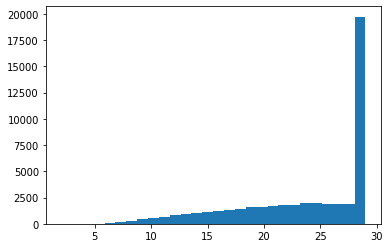

In [30]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

In [31]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205F66F5B08>]],
      dtype=object)

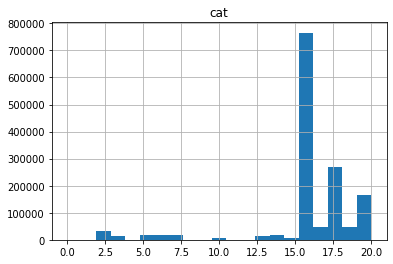

In [32]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [33]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-art,0,345
1,B-eve,1,255
2,B-geo,2,32376
3,B-gpe,3,14570
4,B-nat,4,167
5,B-org,5,18358
6,B-per,6,16018
7,B-tim,7,17657
8,I-art,8,258
9,I-eve,9,207


Interesting. 16 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 17+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [34]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 17]['occurences'].sum()

O_occurences/All_occurences

16    0.8432
Name: occurences, dtype: float64

So **84.4%** is the baseline to beat for our first metric! Can we do that? We'll see.

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [35]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



We now split - in a pretty manual way - the examples into a train and test set. We create a random binary value for each sentence that we use to split train and test data.

In [36]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [37]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [38]:
X_train[0,0]

array([  101, 26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,
        1498,  1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,
        1103, 10602,  1104,  1418,  2830,  1121,  1115,  1583,   119,
         102,     0,     0])

In [39]:
nerLabels_train[0]

array([17, 16, 16, 16, 20, 20, 16, 16, 16,  2, 16, 16, 16, 16, 16,  2, 16,
       16, 16, 16, 16,  3, 16, 16, 16, 16, 16, 19, 18, 18], dtype=int8)

In [40]:
print(sentenceTokenList[0])

['[CLS]', 'Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '[SEP]', '[PAD]', '[PAD]']


Let's also get a few train/test positions:

In [41]:
training_examples[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In the last step, we prepare the actual train and test input and label data. For convenience (quick functionality test on small data set), we introduce parameters k_start & k_end to just use a slide of the full dataset. (Setting k_end to -1 corresponds to using the whole set (as we will do in the following). 

In [42]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

That's it. We are all set to go.

## IV. The Model<a id="model"/>

### IV.1. Custom Loss & Accuracy<a id="custom"/>

We need a **custom loss function** because we only want to optimize for the labels that we actually had in the text, not the extra ones like '[nerPAD]', etc. Our cost function is therefore derived from sparse_categorical_crossentropy, but we choose to modify the function a bit:  we want to mask out all tokens that have a token id larger or equal of 17, corresponding to the extra tokens:  

In [43]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 17)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))


Does it work as advertised? Let's create a toy example:

In [44]:
y_true = tf.constant([[17],[0]])

y_pred = tf.constant([
    [0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])

In [45]:
y_true = tf.constant([[17],[0]])

y_pred = tf.constant([
    [0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print(custom_loss(y_true, y_pred).eval())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.51082695


Compare this to the manual calculation of $-\log((y^1_{pred})_0)$ (remember that $y^0$ is masked out because the true label is 17) 

In [46]:
-np.log(0.6)

0.5108256237659907

So this is correct! The position where the true label is 17 is ignored because of the mask!

In a similar vein, we define and test a **custom accuracy** calculation:

In [47]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 17)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

Let us also define another accuracy calculation that only looks at the non-Other labels: 

In [48]:
def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    calculate loss dfunction explicitly filtering out also the 'Other'- labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 16)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [49]:
y_true = tf.constant([[17],[0]])

y_pred = tf.constant([
    [0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


print(custom_acc_orig_tokens(y_true, y_pred).eval())


1.0


Again... correct! The false value for the '17' example is not considered.

Let's close the session.

In [50]:
sess.close()

Lastly, define an Adam optimizer with new learning rate and beta parameters:

In [51]:
adam_customized = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

### IV.2 Keras BERT Layer<a id="bert_layer"/>


We start by creating a Keras layer for the BERT module from Tensorflow hub. (Note: This code is simply a more specified and for our purposes adjusted version of the equivalent cell in (https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b)   

Note, how then trainable variables are built. (See also: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [52]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url="https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

Next, we define the summary statistics for TensorBoard. And then we can construct the model.

In [53]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### IV.3 Model Construction<a id="ner_model"/>

Time to build the model! Let's be pretty simple. No drop-out etc for now. But we re-train three BERT layers.

In [54]:
def ner_model(max_input_length, train_layers, optimizer):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    print(bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(21, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)


## V. Model Runs/Experiments<a id="runs"/>

### V.1. With BERT-Layer Re-Training<a id="retrain"/>

It is time to run the first test.

In [55]:
#Start session

sess = tf.Session()

model = ner_model(max_length + 1, train_layers=4, optimizer = adam_customized)

# Instantiate variables
initialize_vars(sess)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k }),
    epochs=8,
    batch_size=32#,
    #callbacks=[tensorboard]
)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("bert_layer/bert_layer_module_apply_tokens/bert/encoder/Reshape_13:0", shape=(?, ?, 768), dtype=float32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


pred:  Tensor("ner/truediv:0", shape=(?, ?, 21), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    108931396   input_ids[0][0]                  
                              

**96.8% test accuracy for all original tokens and 83.0% for all original 'non-Other' tokens.... Not bad at all!!** And some tweaking and tuning should probably increase the values a bit more.

Note that we used here the **Adam optimizer with custom values. Did that matter?** Why don't you try it...

### V.2. Predictions & Confusion Matrix<a id="confusion" />


Let us look and see how well the model performs. We use the test here. (It probably would be better to split the data into train/validation/test, we are somewhat casual here).

First, get all of the predictions for the test set:

In [56]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]

result = model.predict(
    bert_inputs_infer, 
    batch_size=32
)

In [57]:
print(result.shape)

(14268, 30, 21)


This is the correct shape: # test sentences x sentence length x # classes. 
Let's get the prediction argmax for a random test sentence:

In [58]:
print(np.argmax(result, axis=2)[6])

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  2 16 16 16  6 14 14 14
 14 16 16 16 16 16]


What were the labels?

In [59]:
print(nerLabels_test[6])

[17 16 20 20 16 20 16 16 16 16 16 16 16 16 16 16  2 16 20 16  6 14 20 14
 14 16 19 18 18 18]


**Wrong? Correct!** Or.. is it?  

**Question: Why are we not bothered by the first and the last 'mistakes', i.e., not identifying 20.17,19,18, etc.?**

Let us now get the confusion matrix:

In [60]:
predictions_flat = [pred for preds in np.argmax(result, axis=2) for pred in preds]
labels_flat = [label for labels in nerLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 17:
        clean_preds.append(pred)
        clean_labels.append(label)


In [61]:
sess = tf.InteractiveSession()

In [62]:
cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
).eval()

Probably a little big and unbalanced to display. Let us focus on the rows/columns with the common labels:

In [63]:
np.sum(cm, axis=0)

array([     6,     39,  10323,   4112,     16,   4839,   4836,   4878,
            4,     34,   1671,     24,      0,   4093,   5101,   1245,
       228489])

In [64]:
cm_most = cm[[2,3,5,6,7,13,14,16],:] [:, [2,3,5,6,7,13,14,16]]

print(cm_most)

[[  8751     51    376    127     10     28     50    306]
 [   211   3954     46      3      0      4      1     30]
 [   690     37   3731    270     10    114     96    422]
 [   162      1    162   4031      0     46    173    179]
 [    83      1     16      4   4482      5      6    498]
 [    83      8    136     69      0   3209    298    358]
 [     8      2     16    185      0    125   4288     72]
 [   186     42    287    131    229    285     98 226125]]


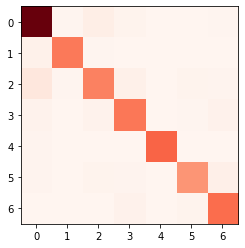

In [65]:
plt.imshow(cm_most[:-1,:-1], cmap='Reds')

Not bad!

In [66]:
sess.close()

### V.3 Without BERT-Layer Retraining ("Did that Help?")

We will re-run the model, but without re-training of the top BERT layer: 

In [67]:
sess = tf.Session()

model = ner_model(max_length + 1,train_layers=0,optimizer='adam')

# Instantiate variables
initialize_vars(sess)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=8,
    batch_size=32#,
    #callbacks=[tensorboard]
)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("bert_layer_1/bert_layer_1_module_apply_tokens/bert/encoder/Reshape_13:0", shape=(?, ?, 768), dtype=float32)
pred:  Tensor("ner_1/truediv:0", shape=(?, ?, 21), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_laye

**Close, but not quite as good.** - While one has to be careful given the different optimizer configurations and number of epochs, it looks as if not re-training BERT - in this case - increased the loss a bit. (It appears also that we over-trained a bit.) Let's call this **~96.5%/81.8%**, had we stopped a bit sooner.

**Side Notes:** 
 * Deeper re-training needs more compute resources
 * Deeper re-training often requires a tuned optimizer
 * Regularization is definitely important...

In [57]:
sess.close()

### V.4. A 90%-Reduced Training Set<a id="tiny"/>


The claim is that BERT is also very useful if one doesn't have much data. So let us see what happens if we cut the training data down to 10%. That leaves us with only ~3400 training examples. Not much...

In [58]:
X_train.shape

(3, 33690, 30)

In [59]:
numTrainSentences = 3370

bert_inputs_train_tiny = [bert_inputs_train_k[0][:numTrainSentences,:], \
                          bert_inputs_train_k[1][:numTrainSentences,:], \
                          bert_inputs_train_k[2][:numTrainSentences,:]]

In [60]:
labels_train_tiny = labels_train_k[:numTrainSentences,:]

In [61]:
sess.close()

In [62]:
sess = tf.Session()

model = ner_model(max_length + 1,train_layers=0,optimizer='adam')

# Instantiate variables
initialize_vars(sess)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.fit(
    bert_inputs_train_tiny, 
    {"ner": labels_train_tiny },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=8,
    batch_size=32#,
    #callbacks=[tensorboard]
)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0727 14:00:43.336763 139635640141632 saver.py:1483] Saver not created because there are no variables in the graph to restore


Tensor("bert_layer_2/bert_layer_2_module_apply_tokens/bert/encoder/Reshape_13:0", shape=(?, ?, 768), dtype=float32)
pred:  Tensor("ner_2/truediv:0", shape=(?, ?, 21), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 30)           0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 30)           0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)  

Not too bad, one would think! **~95.5%/75.7%** on the test set, compared to ~96.5%/81.8% on the full training set with 10x the data! So BERT is serving quite well for a smaller data set. 

In [63]:
sess.close()

## VI. Summary<a id="summary" />

This finishes this cursory analysis of "BERT for NER". We pre-formatted our dataset, took care of tokenization and new inserted tokens (and labels!), defined a baseline model, and then - it would have been embarassing if we had failed - soundly beat the baseline with our Keras-based BERT+classification model. We saw that retraining of some BERT layers appeared to work well.  
We also saw that even a small training set of about 3400 sentences did quite well using this architecture.

All in all, we hope that this notebook was useful and despite its length reasonably readable.